# Sparse Gaussian Process: an exploration

**Computational Statistics Project (2021-22). Jaime Enríquez Ballesteros.**

"*Gaussian process (GP) models are flexible probabilistic nonparametric models for regression,
classification and other tasks. Unfortunately they suffer from computational intractability for
large data sets. Over the past decade there have been many different approximations
developed to reduce this cost. Most of these can be termed global approximations, in that they
try to summarize all the training data via a small set of support points. A different approach is
that of local regression, where many local experts account for their own part of space. In this
project we are interested to study the regimes in which these different approaches work well
or fail, and then apply a new sparse GP approximation which is a combination of both the
global and local approaches, and look extremely promising.*"

General imports:

In [27]:
import pandas as pd
import GPflow.gpflow as gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from GPflow.gpflow.config import default_float, default_jitter
from GPflow.gpflow.utilities import print_summary, set_trainable, to_default_float
from GPflow.gpflow.models import maximum_log_likelihood_objective, training_loss_closure
from GPflow.gpflow.ci_utils import ci_niter

from sklearn.metrics import mean_squared_error

from timeit import default_timer as timer

import scipy.io

## Introduction

This project covers different techniques which might be used when wanting to use a Gaussian Process Regression while having a big dataset. As it will be shown, this is a big problem since as the dataset being used gets bigger, the problem becomes computationally intractable.

The solution at hand is that of Sparse Gaussian Process Regression, which try to approximate the posterior distribution of the real Gaussian Process Regression model without loosing too much information about the data.Two main groups can be distinguished: local and global methods. Several models have been proposed which combine "*the best of both worlds*": a combination between both. All of these will be explained in the following sections.

The project is focused in understanding GPR and SGPR, with the help of the articles by *Snelson and Ghahramani(2007)* and *Titsias (2009)* (found at the bottom of the document). The principal focus is made on the former. A reproducibility objective seems interesting with regard to this articles, as well as an expansion with an external database.

The programming framework used to model Gaussian Processes is *GPFlow* (https://www.gpflow.org/): similar to GPyTorch, only implemented through TensorFlow.

As a sidenote about the framework, we have to take into mind that not EVERY possibility is available among the huge world of Gaussian Processes. It is also a young framework, with little documentation.

To compress these ideas in a single list of objectives, we have:

**Objectives of the project:**
1. Understand Sparse Gaussian Process Regression on big volume datasets.
2. Understand how they are implemented in GPFlow library and the different models we can find.
3. Try to reproduce experimentation on *Snelson & Ghahramani* (2007) and *Titsias* (2009) to understand how these models work.

### General Functions implemented

In [13]:

def plot_univariate(model, color, ax, lims=[-1,11], show_xs=True, show_ind_locations=True):
    x = model.data[0]
    y = model.data[1]
    xx = np.linspace(lims[0], lims[1], 100).reshape(-1, 1)
    mu, var = model.predict_y(xx)
    ax.plot(xx, mu, color, lw=2)
    ax.fill_between(
        xx[:, 0],
        mu[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mu[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color=color,
        alpha=0.2,
    )
    if show_xs:
        ax.plot(x, y, "k,", mew=2)
    if show_ind_locations:
        try:
            ax.plot(np.array(model.inducing_variable.variables[0]),
                    np.repeat(min(mu[:, 0] - 1.96 * np.sqrt(var[:, 0])) - 1, N_ind),
                    'rx')
        except:
            pass
    # Plot title
    ax.set_title(type(model).__name__)
    ax.set_xlim(lims[0], lims[1])


def create_models(data,
                  inducing_variable,
                  optimize=True,
                  opt=gpflow.optimizers.Scipy(),  # BFGS
                  niter=100,
                  verbose=False
                  ):
    n_dim=data[0].shape[1]
    kernel = gpflow.kernels.Matern32(lengthscales=np.ones(n_dim))
    m1 = gpflow.models.GPR(data, kernel=kernel)

    kernel = gpflow.kernels.Matern32(lengthscales=np.ones(n_dim))
    m2 = gpflow.models.SGPR(
        data, kernel=kernel, inducing_variable=inducing_variable
    )
    set_trainable(m2.inducing_variable, False)

    kernel = gpflow.kernels.Matern32(lengthscales=np.ones(n_dim))
    m3 = gpflow.models.GPRFITC(
        data, kernel=kernel, inducing_variable=inducing_variable
    )
    set_trainable(m3.inducing_variable, False)

    kernel = gpflow.kernels.Matern32(lengthscales=np.ones(n_dim))
    m4 = gpflow.models.GPRPITC(
        data, kernel=kernel, inducing_variable=inducing_variable
    )
    set_trainable(m4.inducing_variable, False)


    models = [m1,m2,m3, m4]

    if verbose:
        for model in models:
            print_summary(model)

    times = []
    if optimize:
        # Optimize models
        for model in models:
            print("Starting training of ", type(model).__name__)
            loss_closure = training_loss_closure(model, data)
            start = timer()
            opt.minimize(
                loss_closure,
                variables=model.trainable_variables,
                options=dict(maxiter=ci_niter(100))
            )
            end = timer()
            print("Finished training of ", type(model).__name__)
            times.append(end-start)


    return models, times


def create_models_md(data,
                  inducing_variable,
                  optimize=True,
                  opt=gpflow.optimizers.Scipy(),  # BFGS
                  niter=100,
                  verbose=False
                  ):
    n_dim=data[0].shape[1]

    kernel = gpflow.kernels.Matern32(lengthscales=np.ones(n_dim))
    m2 = gpflow.models.SGPR(
        data, kernel=kernel, inducing_variable=inducing_variable
    )
    set_trainable(m2.inducing_variable, False)

    kernel = gpflow.kernels.Matern32(lengthscales=np.ones(n_dim))
    m3 = gpflow.models.GPRFITC(
        data, kernel=kernel, inducing_variable=inducing_variable
    )
    set_trainable(m3.inducing_variable, False)

    models = [m2,m3]

    if verbose:
        for model in models:
            print_summary(model)

    times = []
    if optimize:
        # Optimize models
        for model in models:
            print("Starting training of ", type(model).__name__)
            loss_closure = training_loss_closure(model, data)
            start = timer()
            opt.minimize(
                loss_closure,
                variables=model.trainable_variables,
                options=dict(maxiter=ci_niter(100))
            )
            end = timer()
            print("Finished training of ", type(model).__name__)
            times.append(end-start)


    return models, times


# m.predict_f -> returns the mean and variance of 𝑓 at the points Xnew
# m.predict_f_samples -> returns samples of the latent function.
# m.predict_y -> returns the mean and variance of a new data point (that is, it includes the noise variance).
def mse_test(model, test_data):
    test_set, test_labels = test_data
    X_t = tf.convert_to_tensor(test_set, dtype=default_float())
    mean, var = model.predict_y(X_t)
    return mean_squared_error(mean, test_labels)



# m.predict_density -> returns the log density of the observations Ynew at Xnew.
def nlpd_test(model, test_data):
    N = test_data[0].shape[0]
    return 1/N*np.sum(model.predict_log_density(test_data))


def error_vs_time(times, mses, nlpds,
                  markers=['.', '.', 'o', '+'],
                  colors=['black', 'red', 'blue', 'black'],
                  mfcs=[False, False, True, False],
                  model_names=['SGPR', 'FITC', 'Local Method']):

    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    # MSE vs time/s
    for i in range(len(times)):
        axs[0].scatter(times[i],
                       mses[i],
                       marker=markers[i],
                       facecolors='none' if mfcs[i] else colors[i],
                       edgecolors=colors[i],
                       label=model_names[i])

    axs[0].legend()
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("time/s")
    axs[0].set_title("MSE vs time")

    # NLPD vs time/s
    for i in range(len(times)):
        axs[1].scatter(times[i],
                       nlpds[i],
                       marker=markers[i],
                       facecolors='none' if mfcs[i] else colors[i],
                       edgecolors=colors[i],
                       label=model_names[i])

    axs[1].legend()
    axs[1].set_ylabel("NLPD")
    axs[1].set_xlabel("time/s")
    axs[1].set_title("NLPD vs time")


## Introduction to Sparse Gaussian Process Regression

### Why do we need Sparse GPR? A quick recap.

A Gaussian Process Regression model has the following prior and predictive distributions:

![](img/Table_3.png)

With a joint distribution of training and test outputs $p(y, y_T)=\mathcal(N)(0, K_{N+T} + \sigma^2 I)$ ($\sigma^2$ being the variance of the noise).

One can see that to compute both the mean and covariance for the predictive distribution, a big inversion must take place. When the data used to compute the covariance is big, the computational effort is excessive (it costs $\mathcal{O}(N^3)$). If a precomputation step is done, such that the mean function is seen as a wighted sum of N basis functions, the mean has a cost of $\mathcal{O}(N)$ while the covariance $\mathcal{O}(N^2)$.

This cost depending on the number of points in the data (N) is far too big. Sparse Gaussian Process Regression models, on the other hand, obtain a much smaller cost.

## Types of Sparse Gaussian Process Regression models.

From the multitude of papers and models one can find about Sparse GPR models, this project focuses on the proposals presented in *Snelson & Ghahramani (2007)*. Here, a distinction is made between:
* **Global approaches**: where the idea behind is to use a set of support points which can summarize the whole dataset. A similar procedure to the original GPR is used using only the support points. This is the reason for the term *global*.

* **Local approaches**: where data is grouped such that a GPR model is deployed for each of this blocks. The posterior distribution for a test point will correspond to the block to which this point belongs to. Such is, a *local* approach.

In the paper mentioned above, a recap of two global methods are presented. These are the FIC (Fully Independent Conditional) and FITC (Fully Independent (Training) Conditional) approximations. Given a set of inducing points $\overline{f}$, the GP prior is expressed as:

$$
p(f,f_t) = \int d\overline{f} \text{  } p(f,f_T | \overline{f})  \text{  } p(\overline{f})
$$

From here, it is assumed that $f$ and $f_T$ are independent given $\overline{f}$:

$$
p(f,f_T) \approx q(f,f_T) = \int d\overline{f} \text{  } q(f_T | \overline{f}) \text{  } q(f | \overline{f})  \text{  } p(\overline{f})
$$

The FITC and FIC differ on the different following assumptions made on the training and test conditionals.

### FIC
For the first of the Fully Independent global approximations, the assumption is made that both the training and test conditionals are fully independent s.t. $q(f|\overline{f})=\prod\limits_n{p(f_n|\overline{f})}$ and $q(f_T|\overline{f})=\prod\limits_t{p(f_t|\overline{f})}$. 

As a result the prior and predictive distributions found are the ones found in the first row of Table 1.

### FITC
This second global approximation only considers the *training* data points to be independent. We find the same conditional for training points as before: $q(f|\overline{f})=\prod\limits_n{p(f_n|\overline{f})}$; but, now, the test conditional: $q(f_T|\overline{f})=p(f_T|\overline{f})$.

This will transform into a different covariance prior in the testing points slots, as shown in Table 1.

![Table 1](img/Table_1.png)

## Global + Local approach

Both global and local approaches present very good qualities. They also show disadvantages which are, somehow, complementary of each other. This is the main motivation to search for a method which combines both approaches.

As a first proposal, in *Snelson & Ghahramani (2007)* we find the PITC (Partially Independent Training Conditional).

### PITC

First proposed in *Quiñonera and Rasmussen (2005)*, the PITC method follows the steps of FITC. As a first step, the training points are divided into blocks $  X_{B_s}, f_{B_s} $ being $s \in S$ each of the blocks.

PITC assumes *partial independence* for the training points. Independence is only considered for points which do not belong to the same block. Following the same notation as FI(T)C, the training and test conditionals are: $q(f|\overline{f})=\prod\limits_s^S{p(f_{B_s}|\overline{f})}$ and $q(f_T|\overline{f})=p(f_T|\overline{f})$.

These conditionals probabilities make us understand that the covariance prior will have to be composed by a *block-diagonal* taken of the original training points. The blocks of the block-diagonal matrix being covariance sub-matrices of the original covariance matrix (minus the new sparse diagonal $Q_N$). The corresponding formulas for the predictive distribution (on test point $f_*$) are shown in Table 2.

### PIC

A new approach is developed in *Snelson & Ghahramani (2007)* following the steps of PITC. The motivation for it is that PITC is still to similar to FITC (as we can see by comparing the predictive distributions). One can not expect too much difference between the two. Another important issue is that the blocking scheme in the training points marginalizes the testing points into a block of their own. Meaning that the test points are related to the training points only through the inducing points. An issue we wanted to avoid when combining global and local methods.

The new approach, named PIC, treats training and testing points and considers them jointly for the blocking scheme. This results in a joint conditional: $q(f, f_T|\overline{f})=p(f_{B_s}, f_T|\overline{f}) \prod\limits_s^{S-1}{p(f_{B_s}|\overline{f})}$.

The corresponding predictive distribution is shown in Table 2.

![](img/Table_2.png)

Of course, two questions come to mind about the methods shown above.
* **Where to put / How many inducing points** to obtain the best model possible?
* **How big / How many blocks** should be appointed?

Usually, the location of inducing points is decided randomly. Although an interesting proposal is choosing the corresopnding location of inducing points based on the clusters formed in the local-part of the method.

Regarding how many inducing points to appoint, the only requirement is that this number should be much smaller than the original number of data points ($M<<N$).

The size of the blocks is usually the same for every block. So the size and number of blocks usually have a direct relation. According to *Quiñonera and Rasmussen (2005)*, "*A reasonable choice, recommended by Tresp (1999) may be to choose k = n/m blocks.*" i.e. the number of total points divided by the number of inducing points.

It is important to mention that when the number of inducing points or blocks in the model is increased greatly, it will tend to a GP Regresion model (since $Q=K$). 
On the other spectrum, when block sizes tend to one we obtain the FIC model. Furthermore, when the inducing points tend to zero, we are left with the original local GP predictor.

## Variational Learning approaches

In the article *Titsias (2009)*, a new Global method is proposed. It is based on Variational Learning, a family of techniques for approximating intractable integrals arising in Bayesian inference and machine learning.

A in-depth explanation of it is given in the *bibliography/VariationalInference.pdf* document.

But the main idea is that it largely solves two problems: scalability for large datasets and inferring the location of inducing points.

A GPflow implementation of this method is present. It is can be found in *gpflow/models/sgpr.py* named SGPR.
We will use it to compare it to the other Sparse models.

## Implementation of Local, PITC and PIC methods in GPflow context

Unfortunetely, there exists no implementation of a Local method, nor PITC or PIC in GPflow.
This is why, a possible implementation is carried out.

The implementation for a Local method uses a K-means model to construct the blocks. For each of these blocks, a GPR model is created. The implementation can be found in the file *gpflow/models/sgpr.py*.
A possible approach was tried, using the FITC model as the basis for each of the blocks, but the difference in both execution time and error was very little.

Regarding the implementation for the PITC model, a new class is implemented, using the same methods as FITC, except changing the calculation of the prior distribution, since we now should take into account the dependence between points belonging to the same block. A new function is implemented, creating blocks from which a block-diagonal is calculated (as explained above).

Unfortunetely, the method shows predictions with a much higher computational effort than expected, probably because of the way it has been implemented. Such is, we can clearly see that the implementation has big room for improvement. The implementation can be found in the file *gpflow/models/sgpr.py*.

The fact that there is little documentation regarding the coding process of the GPR models of GPflow is also a big disadvantage when wanting to carry out something similar to a new implementation.

As for the PIC model, a possible class was implemented. But no execution was done. The implementation can be found in the file *gpflow/models/sgpr.py*

## Simple Guassian Regression Example (d=1)

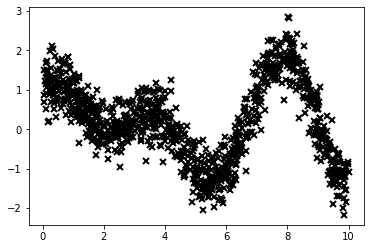

In [17]:
np.random.seed(42)
N = 1000
N_t = 100
N_ind = 10
X = np.random.rand(N, 1) * 10
Y = np.sin(X) + 0.9 * np.cos(X * 1.6) + np.random.randn(*X.shape) * 0.4
Xtest = np.random.rand(N_t, 1) * 10
_ = plt.plot(X, Y, "kx", mew=2)
plt.show()

In [18]:
data = (
    tf.convert_to_tensor(X, dtype=default_float()),
    tf.convert_to_tensor(Y, dtype=default_float()),
)
X_ind = X[0:N-1:int(N/N_ind)]
inducing_variable = tf.convert_to_tensor(X_ind, dtype=default_float())

In [19]:
# Create models
models, _ = create_models(data, inducing_variable)

GPR, SGPR, FITC, PITC = models
LocalGPR = gpflow.models.LocalGPR(data,gpflow.kernels.SquaredExponential(), num_blocks=10)
LocalGPR.optimize()


Starting training of  GPR
Finished training of  GPR
Starting training of  SGPR
Finished training of  SGPR
Starting training of  GPRFITC
Finished training of  GPRFITC
Starting training of  GPRPITC
Finished training of  GPRPITC


[0.36447993099864107,
 0.33804636199784,
 0.3791656520043034,
 0.37685600000259,
 0.32929757500096457,
 0.3397334379988024,
 0.3669172050067573,
 0.3776202450026176,
 0.3148834759995225,
 0.2719286159990588]

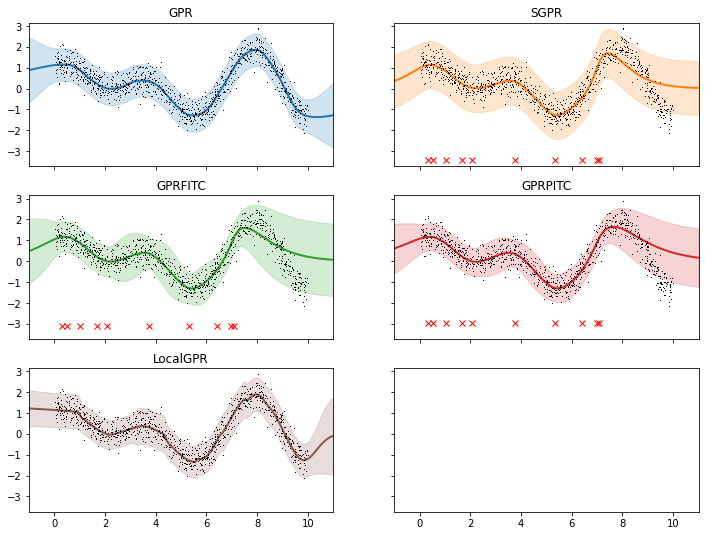

In [21]:
# Plot results
f, ax = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=True)
plot_univariate(GPR, "C0", ax[0, 0], show_xs=True)
plot_univariate(SGPR, "C1", ax[0, 1], show_xs=True)
plot_univariate(FITC, "C2", ax[1, 0], show_xs=True)
plot_univariate(PITC, "C3", ax[1, 1], show_xs=True)
plot_univariate(LocalGPR, "C5", ax[2, 0], show_xs=True)
plt.show()

## Comparison between Guassian Process Models

From the plot above, we can clearly see the differences between the models.
For the GPR we can see a very well fitted posterior distribution, while for the SGPR and FITC models, it is clear that the error bands are larger.

For the PITC model, we can a see a clear combination between the Local GPR model, with a small error band in the data domain, while a big increase at the two ends of the domain, like the FITC method.

The local model is a clear combination of many GPR submodels on each block. One can see that there is very little smoothness in the predictive distribution, as one would expect.

## Reproduction of previous experiments found in *Snelson & Ghahramani* (2007) and *Titsias* (2009)

For the execution of the methods for some typical GP Regression datasets, we will just use the Local, FITC and SGPR (VFE) models.
This is because the GPR and PITC methods cannot be run on a local computer, since their implementations carry big operations. The latter's innability to be executed with a huge dataset (when in theory it should) surely comes from the way it was implemented.

So, in this section, a comparation between the Local approach, FITC and SGPR methods will be shown. Since no clear plotting is possible due to high dimensionality, the plots shown compare the models time of execution vs their respective errors. The errors used (as in the original article of *Snelson & Ghahramani (2007)* will be Mean Squared Error and Negative Log Predictive Density). At the top of the document can one find the corresponding implementation.

### Kin40k dataset

40,000 records describing the location of a robotic arm as a function of an 8-dimensional control input

In [14]:
# Load data
kin40k = np.loadtxt("data/kin40k/kin40k_train_data.asc") # Toy example of kin40k
kin40k_l = np.loadtxt("data/kin40k/kin40k_train_labels.asc").reshape(-1, 1) # Toy example of kin40k
kin40k_test = np.loadtxt("data/kin40k/kin40k_test_data.asc", skiprows=29000) # Toy example of kin40k
kin40k_test_l = np.loadtxt("data/kin40k/kin40k_test_labels.asc", skiprows=29000).reshape(-1, 1) # Toy example of kin40k
N = len(kin40k)
N_t = len(kin40k_test)
N_ind = len(kin40k) * 0.01  
n_dim = kin40k.shape[1]

kin40k_data = (
    tf.convert_to_tensor(kin40k, dtype=default_float()),
    tf.convert_to_tensor(kin40k_l, dtype=default_float()),
)
kin40k_test_data = (
    tf.convert_to_tensor(kin40k_test, dtype=default_float()),
    tf.convert_to_tensor(kin40k_test_l, dtype=default_float()),
)
kin40k_ind = kin40k[0:N-1:int(N/N_ind)]
kin40k_ind = tf.convert_to_tensor(kin40k_ind, dtype=default_float())

# https://github.com/GPflow/GPflow/issues/1606
models, times = create_models_md(kin40k_data, kin40k_ind)
SGPR, FITC = models

LocalGPR = gpflow.models.LocalGPR(kin40k_data,  gpflow.kernels.SquaredExponential(lengthscales=np.ones(n_dim)), num_blocks=100)
times.append(sum(LocalGPR.optimize()))

Starting training of  SGPR
Finished training of  SGPR
Starting training of  GPRFITC
Finished training of  GPRFITC


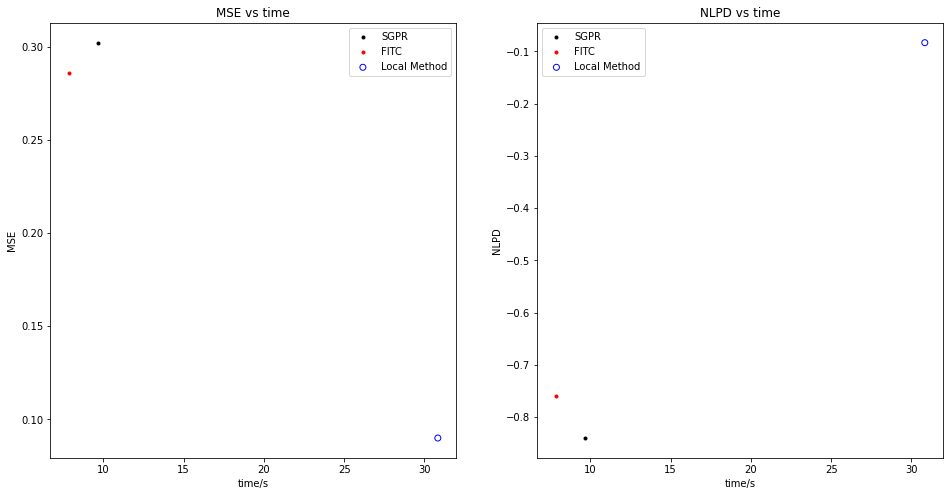

In [15]:
# Evaluation of kin40k
kin40k_mses = [
               mse_test(SGPR, kin40k_test_data),
               mse_test(FITC, kin40k_test_data),
               mse_test(LocalGPR, kin40k_test_data)]

kin40k_nlpd = [nlpd_test(SGPR, kin40k_test_data),
               nlpd_test(FITC, kin40k_test_data),
               nlpd_test(LocalGPR, kin40k_test_data)]


error_vs_time(times, kin40k_mses, kin40k_nlpd)
plt.show()

### Abalone dataset

Predicting the age of abalone from physical measurements. The age of abalone is determined by
cutting the shell through the cone, staining it, and counting the number of rings through a
microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain,
are used to predict the age.

In [36]:

abalone = pd.read_csv('data/abalone/abalone.data', header=None)
N = len(abalone)
test_pct = .2
abalone_test = abalone.iloc[:int(N*test_pct),:]
abalone_test_l = np.array(abalone_test.iloc[:,-1]).reshape(-1,1)
abalone_test = abalone_test.iloc[:,:-1].drop(0, axis=1)

abalone = abalone.iloc[int(N*test_pct):,:]
abalone_l = np.array(abalone.iloc[:,-1]).reshape(-1,1)
abalone = abalone.iloc[:,:-1].drop(0, axis=1)

N = len(abalone)
N_t = len(abalone_test)
N_ind = len(abalone) * 0.01
n_dim = abalone.shape[1]

abalone_data = (
    tf.convert_to_tensor(abalone, dtype=default_float()),
    tf.convert_to_tensor(abalone_l, dtype=default_float()),
)
abalone_test_data = (
    tf.convert_to_tensor(abalone_test, dtype=default_float()),
    tf.convert_to_tensor(abalone_test_l, dtype=default_float()),
)
abalone_ind = abalone[0:N-1:int(N/N_ind)]
abalone_ind = tf.convert_to_tensor(abalone_ind, dtype=default_float())

abalone_data

(<tf.Tensor: shape=(3342, 7), dtype=float64, numpy=
 array([[0.45  , 0.35  , 0.13  , ..., 0.245 , 0.1405, 0.1405],
        [0.47  , 0.375 , 0.12  , ..., 0.266 , 0.0935, 0.169 ],
        [0.475 , 0.365 , 0.125 , ..., 0.229 , 0.1185, 0.172 ],
        ...,
        [0.6   , 0.475 , 0.205 , ..., 0.5255, 0.2875, 0.308 ],
        [0.625 , 0.485 , 0.15  , ..., 0.531 , 0.261 , 0.296 ],
        [0.71  , 0.555 , 0.195 , ..., 0.9455, 0.3765, 0.495 ]])>,
 <tf.Tensor: shape=(3342, 1), dtype=float64, numpy=
 array([[ 8.],
        [ 8.],
        [ 9.],
        ...,
        [ 9.],
        [10.],
        [12.]])>)

In [37]:

# Training of SARCOS
models, times = create_models_md(abalone_data, abalone_ind)
SGPR, FITC = models

LocalGPR = gpflow.models.LocalGPR(abalone_data,  gpflow.kernels.SquaredExponential(lengthscales=np.ones(n_dim)), num_blocks=100)
times.append(sum(LocalGPR.optimize()))


Starting training of  SGPR
Finished training of  SGPR
Starting training of  GPRFITC
Finished training of  GPRFITC


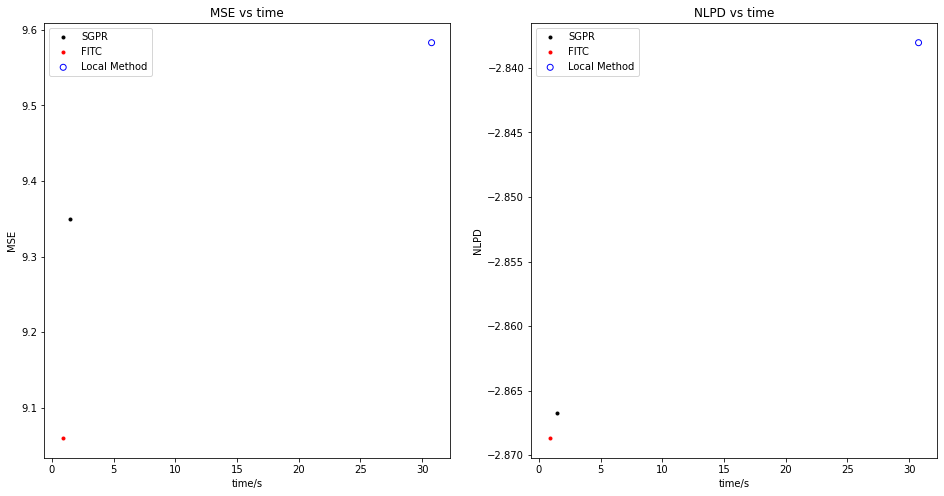

In [39]:

# Evaluation of SARCOS
abalone_mses = [
               mse_test(SGPR, abalone_test_data),
               mse_test(FITC, abalone_test_data),
               mse_test(LocalGPR, abalone_test_data)]

abalone_nlpd = [
               nlpd_test(SGPR, abalone_test_data),
               nlpd_test(FITC, abalone_test_data),
               nlpd_test(LocalGPR, abalone_test_data)]

error_vs_time(times, abalone_mses, abalone_nlpd)
plt.show()

## Conclusion

During the project, a series of Sparse Gaussian Process Regression models have been explained, without too many details, as well as implemented through the GPflow library.

Applied to big volume datasets, we have seen that the Sparse approximations allow for a much quicker and less computationally expensive approach.

It is important to note that, as the articles mentioned, no variation of inducing point locations and block size was made, which is what was left to obtain a full reproduction of the experiments carried out in the articles.

### References

1. Snelson and Ghahramani. (2007). Local and global sparse Gaussian process approximations. Artificial Intelligence and Statistics 11 (AISTATS).http://proceedings.mlr.press/v2/snelson07a/snelson07a.pdf
2. Titsias. (2009). Variational Learning of Inducing Variables in Sparse Gaussian Processes. Journal of Machine Learning Research - Proceedings Track. 5. 567-574. http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf
3. Quiñonera and Rasmussen (2005). A Unifying View of Sparse Approximate Gaussian Process Regression.https://www.jmlr.org/papers/v6/quinonero-candela05a.html